# Masking Algorithm

This notebook is a sandbox to design the masking algorithm for training the self-supervised Transformer for this project. The masking algorithm should

- perform missing completely at random
- perform missing in blocks
- perform intermittent missing data (can we randomize length and starting point?)

Each of these should occur in a batch with probabiliy $\epsilon$. 

Each of these should also only affect up to the index where data is present. The sequences are padded with zeros to make them a fixed length. Missing data should not be present when 0 padded.

In [1]:
import DataUtils
import torch
import numpy as np
import matplotlib.pyplot as plt

C:\Users\austi\miniconda3\envs\deep_learn\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Loading Data

In [2]:
trainloader, testloader = DataUtils.get_dataloaders(32, 1)

In [72]:
example = next(enumerate(testloader))
ex_X = example[1][0]
ex_y = example[1][1]

In [11]:
print(ex_X.shape, ex_y.shape)

torch.Size([32, 542, 27]) torch.Size([32])


### Defining Masking Functions

First, mask completely at random. Fill with -1 to signify missing data.

In [79]:
# def mask_random(batched_data):
#     masked = batched_data.clone()
#     percent_missing = np.random.randint(30, 60) / 100
    
#     for row in masked:
#         print(row.shape)
    
#     random_mask = (torch.FloatTensor(masked.shape).uniform_() > percent_missing)

#     masked[random_mask] *= -1
#     masked[masked < 0] = -1
#     return masked

In [193]:
import numpy as np
import torch

def mask_random(batched_data):
    masked = batched_data.clone()
    percent_missing = np.random.randint(30, 60) / 100

    # Find indices of the padded values
    padded_indices = (masked == 0).all(dim=2)

    # Generate random masks for true values only
    true_masks = torch.rand(batched_data.shape) > percent_missing
    true_masks[padded_indices] = False

    # Mask the true values and leave padded values as 0
    masked[true_masks] = -1

    return masked

In [130]:
masked = mask_random(ex_X)

0.46


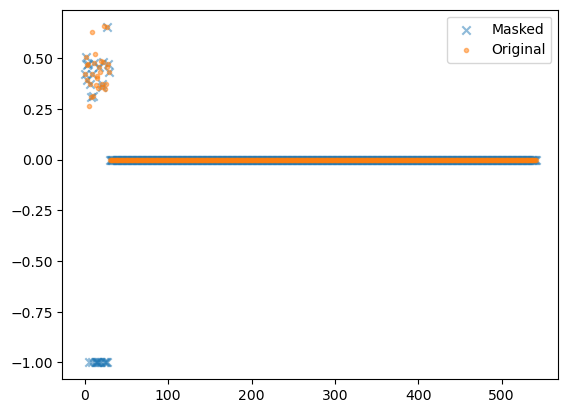

In [134]:
index = 542
plt.scatter(range(index), masked[30][:,7][0:index], label='Masked', alpha=0.5, marker="x")
plt.scatter(range(index), ex_X[30][:,7][0:index], label='Original', alpha=0.5, marker=".")
plt.legend()

In [181]:
def mask_intermittently(batched_data):
    masked = batched_data.clone()
    n_cols = np.random.randint(0, batched_data.shape[2])
    cols = np.random.choice(list(range(n_cols)), n_cols, replace=False)
    checkerboard_mask = np.ones(masked.shape[1])
    checkerboard_mask[0::2] = -1

    masked[:, :, cols] = (masked[:, :, cols] * np.expand_dims(np.expand_dims(checkerboard_mask, 0), 2))
    masked[masked < 0] = -1
    return masked

In [346]:
masked = mask_intermittently(ex_X)

(1, 543, 1)
[5 6 0 3 1 2 7 8 4]


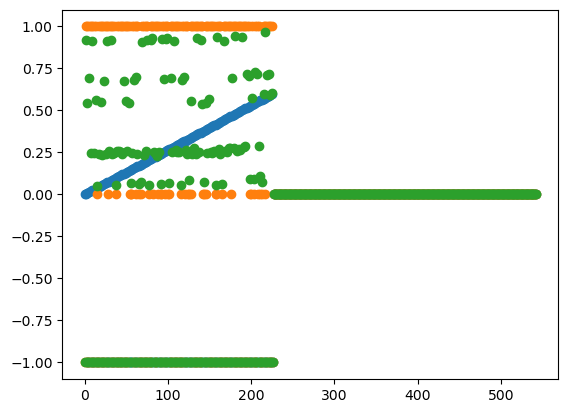

In [347]:
plt.scatter(range(543), masked[0][:,1])
plt.scatter(range(543), masked[0][:,4])
plt.scatter(range(543), masked[0][:,8])

In [192]:
import torch

# Written by ChatGPT
def mask_blocks(batched_data):
    x = batched_data.clone()
    batch_size, seq_len, num_features = x.shape

    # Create a mask tensor to indicate which elements of the tensor should be masked
    mask = torch.zeros((batch_size, seq_len), dtype=torch.bool)

    # Iterate over each element in the batch
    for i in range(batch_size):
        # Get the sequence for the current example
        seq = x[i]

        # Determine the length of the non-padded sequence
        non_padded_len = torch.nonzero(seq[:,2]).shape[0]

        # Randomly select the number of blocks to mask (1-5)
        num_blocks = torch.randint(1, 3, size=(1,)).item()

        # Iterate over each block to mask
        for j in range(num_blocks):
            # Randomly select the length of the block (5-20)
            block_len = torch.randint(0, int(non_padded_len/num_blocks)+1, size=(1,)).item()

            if non_padded_len - block_len + 1 < 1:
                continue
            # Randomly select the start index of the block
            start_index = torch.randint(0, non_padded_len - block_len + 1, size=(1,)).item()
                
            # Mask the selected block
            mask[i, start_index:start_index + block_len] = True

    # Apply the mask to the tensor and replace masked values with -1
    x[mask.unsqueeze(-1).expand_as(x)] = -1

    return x

In [207]:
masked = mask_blocks(ex_X)

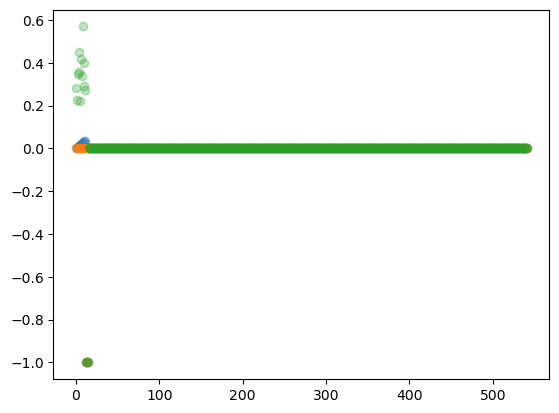

In [174]:
plt.scatter(range(542), masked[15][:,1], alpha=0.3)
plt.scatter(range(542), masked[15][:,4], alpha=0.3)
plt.scatter(range(542), masked[15][:,8], alpha=0.3)

In [201]:
def mask_input(batched_data, only_mask=True):
    min_size = 5
    
    masked_data = []
    batch_size = batched_data.shape[0]
    for i in range(batch_size):
        
        sample = batched_data[i]
        eps = np.random.rand()

        if torch.nonzero(sample[:,2]).shape[0] < min_size:
            masked_data.append(sample)
            continue
            
        if eps > 0.66:
            masked = mask_random(sample.unsqueeze(0))
        elif eps > 0.33:
            masked = mask_intermittently(sample.unsqueeze(0))
        else:
            masked = mask_blocks(sample.unsqueeze(0))
            
        masked_data.append(masked.squeeze(0))
            
    
    return torch.stack(masked_data)

In [202]:
masked = mask_input(ex_X)

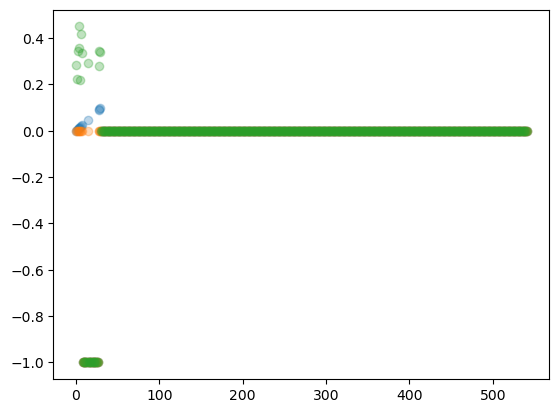

In [206]:
plt.scatter(range(542), masked[30][:,1], alpha=0.3)
plt.scatter(range(542), masked[30][:,4], alpha=0.3)
plt.scatter(range(542), masked[30][:,8], alpha=0.3)